In [1]:
"""
RESSOURCES:
https://gerardmaggiolino.medium.com/creating-openai-gym-environments-with-pybullet-part-1-13895a622b24
SAC in pybullet: https://medium.com/analytics-vidhya/learning-to-walk-using-reinforcement-learning-4e237aaf64a0
architecture inspiration: https://github.com/pat-coady/trpo/tree/master/trpo
virtual env: https://stackoverflow.com/questions/61528500/installing-venv-for-python3-in-wsl-ubuntu

https://linuxhint.com/install-xvfb-ubuntu/
FAKE GUI env:
# prevent any future commands in this session from connecting to your real X environment
unset DISPLAY XAUTHORITY
# run yourcode.py with a fake X environment provided by xvfb-run
xvfb-run python yourcode.py

https://github.com/hermesdt/reinforcement-learning/blob/master/a2c/cartpole_a2c_episodic.ipynb
convergence plot

https://adventuresinmachinelearning.com/a2c-advantage-actor-critic-tensorflow-2/

greadient clipping / mish activation/ continous task
https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c
"""
import gym
import os
import pybullet as p
import pybullet_envs
import pybullet_envs.bullet.racecarGymEnv as e
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import a2cagent

#os.environ["SDL_VIDEODRIVER"] = "dummy"

#client = p.connect(p.GUI) #starts the simulation, GUI enables visualization
client = p.connect(p.DIRECT) #faster connection without visualisation (use for training?)

#env = e.RacecarGymEnv(isDiscrete=False ,renders=True)
#env = gym.make("HopperBulletEnv-v0")
env= gym.make("CartPoleContinuousBulletEnv-v0")
env.reset()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

print(obs_dim, act_dim)

pybullet build time: May 20 2022 19:44:17


current_dir=/home/grube/.local/lib/python3.8/site-packages/pybullet_envs/bullet


2022-11-28 15:00:31.851772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:00:31.981948: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-28 15:00:31.987133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 15:00:31.987150: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

argv[0]=
argv[0]=
4 1


/home/grube/.local/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


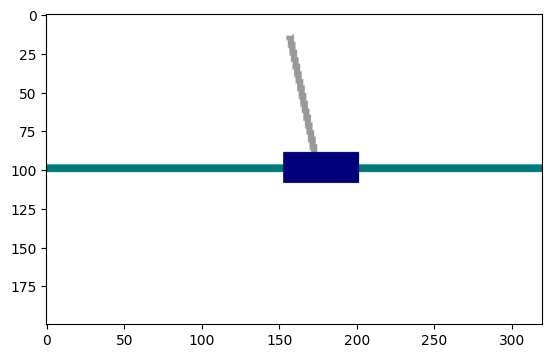

ValueError: too many values to unpack (expected 2)

In [2]:
for _ in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        observation,info=env.reset()
        
    clear_output(wait=True)
    x=env.render(mode='rgb_array')
    plt.imshow( x )
    plt.show()

env.close()

In [15]:
import gym
import pybullet as p
import pybullet_envs
import pygame
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime

env_str='CartPole-v1'
env = gym.make(env_str) #not sure whether this is contiuous?
s0 = env.reset(return_info=False)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space
print (obs_dim)
print (act_dim)

4
Discrete(2)
